In [196]:
from sklearn.model_selection import train_test_split
from data_loader import DataLoader
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
X_train_full, y_train_full = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15)

In [197]:
from random import sample
from numpy import ndarray
from matplotlib import pyplot as plt

def display_randomly_sampled_images(X: ndarray, y: ndarray):
	plt.figure(figsize=(20, 5))
	for i, j in enumerate(sample(range(len(X)), 20)):
		plt.subplot(1, 20, i + 1)
		plt.imshow(X[j])
		plt.axis('off')
		plt.title(class_names[y[j]])

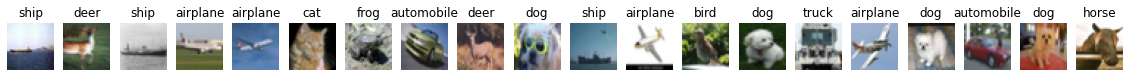

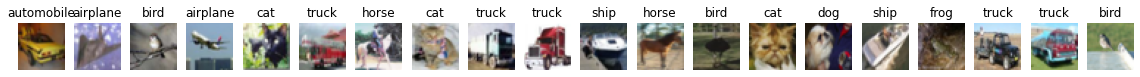

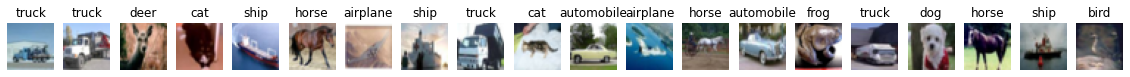

In [198]:
display_randomly_sampled_images(X_train, y_train)
display_randomly_sampled_images(X_val, y_val)
display_randomly_sampled_images(X_test, y_test)

In [233]:
from tensorflow.keras import models, layers, callbacks, Model
from typing import Callable
History_Model = tuple[callbacks.History, Model]
def mlp(kernel_initializer: str, learning_rate_scheduler: Callable[[int, float], float], dropout_rate: float) -> History_Model:
	learning_rate_scheduler_cb = callbacks.LearningRateScheduler(learning_rate_scheduler)
	early_stopping_cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
	model = models.Sequential([
		layers.Flatten(input_shape=X_train.shape[1:], name="input"),
		layers.Dense(500, activation='relu', name="dense_1", kernel_initializer=kernel_initializer),
		layers.Dropout(dropout_rate, name='dropout_1'),
		layers.Dense(100, activation='relu', name="dense_2"),
		layers.Dropout(dropout_rate, name='dropout_2'),
		layers.Dense(len(class_names), activation='softmax', name="output")
	])
	model.compile('sgd', 'sparse_categorical_crossentropy', 'accuracy')
	history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping_cb, learning_rate_scheduler_cb], batch_size=256)
	return history, model

In [200]:
def exponential(epoch, lr0):
	return lr0 * 0.1 ** (epoch / 5)

In [201]:
def power(epoch, lr0):
	return lr0 / (1 + epoch / 5)

In [202]:
def grid_search(hyperparameters1: list, hyperparameters2: list, hyperparameters3: list, model):
	models: dict[str, tuple[callbacks.History, Model]] = {}
	for i in hyperparameters1:
		for j in hyperparameters2:
			for k in hyperparameters3:
				models[f'{i} {j.__name__} {k}'] = model(i, j, k)
	return models

In [203]:
import pandas as pd
def visualise(grid_search_res: dict[str, History_Model]) -> tuple[Model, str]:
	i = 0
	j = 0
	fig, axes = plt.subplots(2, 4, figsize=(20, 10))
	best_model = None
	max_accuracy = 0
	best_params = ''
	for key, value in grid_search_res.items():
		history, model = value
		df = pd.DataFrame(history.history)
		accuracy = df['val_accuracy'].max()
		if (max_accuracy < accuracy):
			max_accuracy = accuracy
			best_model = model
			best_params = key
		df.plot(ax=axes[j, i], title=key)
		i += 1
		if i == 4:
			i = 0
			j += 1
	return best_model, best_params

In [204]:
import json
def save_best_model(hyperparameters1: list, hyperparameters2: list, hyperparameters3: list, model: Callable):
	grid_search_res = grid_search(hyperparameters1, hyperparameters2, hyperparameters3, model)
	with open(f'{model.__name__}.json') as fp:
		json.dump(grid_search_res, fp)
	best_model, best_params = visualise(grid_search_res)
	kernel_initializer, learning_rate_scheduler, dropout_rate = best_params.split()
	best_model.save(f'{NAME}-{model.__name__.upper()}', save_format='tf')
	print('Best parameters')
	print(f'kernel initializer: {kernel_initializer}')
	print(f'learning rate scheduler: {learning_rate_scheduler}')
	print(f'dropout rate: {dropout_rate}')
	return best_model

In [205]:
import math
def cnn(kernel_size: int, num_of_kernels: int, activation: str) -> History_Model:
	def scheduler(epoch, lr):
		if epoch < 10:
			return lr
		else:
			return lr * math.exp(-0.1)
	learning_rate_scheduler_cb = callbacks.LearningRateScheduler(scheduler)
	early_stopping_cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
	model = models.Sequential([
		layers.Conv2D(num_of_kernels, kernel_size, activation=activation, padding='same', input_shape=X_train.shape[1:], name='input'),
		layers.MaxPool2D(name='max_pooling'),
		layers.Conv2D(num_of_kernels * 2, 3, activation='relu', padding='same', name='convolution'),
		layers.Flatten(name='flattern'),
		layers.Dense(100, activation='relu', name='dense'),
		layers.Dropout(0.5, name='dropout'),
		layers.Dense(len(class_names), activation='softmax', name='output')
	])
	model.compile('sgd', 'sparse_categorical_crossentropy', 'accuracy')
	history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping_cb, learning_rate_scheduler_cb], batch_size=256)
	return history, model

In [ ]:
from os import path
NAME = 'Liang_Kaiqi'
mlp_model: Model = None
cnn_model: Model = None
if path.isdir(f'{NAME}-MLP') and path.isdir(f'{NAME}-CNN'):
	mlp_model = models.load_model(f'{NAME}-MLP')
	mlp_model.fit(X_train, y_train)
	cnn_model = models.load_model(f'{NAME}-CNN')
	cnn_model.fit(X_train, y_train)
else:
	mlp_model = save_best_model(['he_normal', 'glorot_uniform'], [exponential, power], [0.05, 0.3], mlp)
	cnn_model = save_best_model([5, 7], [32, 64], ['relu', 'selu'], cnn)
mlp_model.summary()
cnn_model.summary()

In [221]:
from sklearn import metrics
import numpy as np
y_pred: ndarray = y_pred
print(metrics.accuracy_score(y_test, y_pred))
for i in range(10):
	f = lambda x: x == i
	binary_pred = f(y_pred)
	binary_test = f(y_test)
	print(class_names[i])
	print(f'f1: {metrics.f1_score(binary_pred, binary_test)}')
	print(f'precision: {metrics.precision_score(binary_pred, binary_test)}')
# y_pred: ndarray = np.argmax(mlp_model.predict(X_test), axis=-1)
# y_pred = np.argmax(cnn_model.predict(X_test), axis=-1)
# print(metrics.accuracy_score(y_test, y_pred))

0.3783
airplane
f1: 0.43851286939942796
precision: 0.46
automobile
f1: 0.433
precision: 0.433
bird
f1: 0.26034858387799564
precision: 0.239
cat
f1: 0.19228165199729183
precision: 0.142
deer
f1: 0.3264864864864865
precision: 0.302
dog
f1: 0.34069400630914826
precision: 0.378
frog
f1: 0.41549595572584075
precision: 0.488
horse
f1: 0.38541099618943925
precision: 0.354
ship
f1: 0.4716391246092006
precision: 0.528
truck
f1: 0.43818615751789974
precision: 0.459
